# Style Transfer
Here we implement the style transfer algorithm of https://arxiv.org/pdf/1508.06576.pdf to transfer the style of Van Gogh's starry night to a photograph of a European town

In [0]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm
!pip3 install pillow==4.0.0

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
import torchvision.models as models
import torchvision
from tqdm import tqdm
from torch.autograd import Variable
 
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type

from torch.nn.parameter import Parameter
import pdb
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

from PIL import Image
import io
 
from google.colab import files

# Helper Classes and Functions

In [0]:
class ImageDataset(Dataset):
  def __init__(self, root, download=True, size=224):
#     if download and not os.path.exists(os.path.join(root, 'content.png')) and not os.path.exists(os.path.join(root, 'style.png')):
    datasets.utils.download_url('http://liftothers.org/dokuwiki/lib/exe/fetch.php?media=cs501r_f2018:content.png', root, 'content.png', None)
    datasets.utils.download_url('http://liftothers.org/dokuwiki/lib/exe/fetch.php?media=cs501r_f2018:style.png', root, 'style.png', None)

    # Initialize a transform to transform our images to the desire format
    load_and_normalize = transforms.Compose([
        transforms.Resize((size,size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ])
    self.dataset = torchvision.datasets.ImageFolder('/tmp', transform=load_and_normalize)
    
  def __getitem__(self,index):
    return self.dataset[index][0].unsqueeze(0)

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    
    self.intermediates = {}
    self.vgg = models.vgg19(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to replace the relu functions with in place functions. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
          
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(x)  
    return self.intermediates
  
def show(img):
  """Displays the image in line
  
  Parameters:
    img (1 x 3 x a x b Tensor): An image in the Pytorch Tensor format
  """
  std = torch.Tensor([0.229, 0.224, 0.225])
  mean= torch.Tensor([0.485, 0.456, 0.406])
  img = img.squeeze(0).permute(1,2,0)
  img = img * std + mean
  img = img.clamp(0, 1)
  plt.imshow(img, interpolation='nearest')
  
  plt.grid(False)
  plt.axis('off')
  
def normalize_img(input_image):
  

# Content-Style Loss Function

In [0]:
class ContentStyleLoss(nn.Module):
  def __init__(self, content_img, style_img):
    super(ContentStyleLoss, self).__init__()
    
    class ContentLoss(nn.Module):
      def __init__(self, content_img):
        super(ContentLoss, self).__init__()
        
        """
        These are the layers of the VGG network that we index into with 'requested_vals'
        ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", 
         "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2",
         "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3",
         "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4",
         "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]
        """
        # Requested vals correspond to the layers that correspond to content we want to match
        requested_vals = [17]
        self.vgg = VGGIntermediate(requested=requested_vals)
        self.vgg.cuda()
        self.content_layers = list(self.vgg(content_img.cuda()).values())
  
      def forward(self, input_image):
        input_image_layers = list(self.vgg(input_image.cuda()).values())
        content_loss = torch.sum(torch.stack([F.mse_loss(input_image_layer, content_layer) for input_image_layer, content_layer in zip(input_image_layers, self.content_layers)]))
        return content_loss
    
    class StyleLoss(nn.Module):
      def __init__(self, style_img):
        super(StyleLoss, self).__init__()
                
        # Requested vals correspond to the layers that correspond to content we want to match
        requested_vals = [0, 5, 10, 17, 24]
        self.vgg = VGGIntermediate(requested=requested_vals)
        self.vgg.cuda()
        self.style_layers = list(self.vgg(style_img.cuda()).values())
        # Preprocess these so we don't compute them every time we compute the loss
        self.gram_matrices = [self.compute_gram(feature_map) for feature_map in self.style_layers]
        
      def compute_gram(self, feature_map):
        b, c, h, w = feature_map.size()
        feature_map = feature_map.view(b * c, h * w)
        gram = feature_map @ feature_map.t()
        return gram
      
      def forward(self, input_image):
        input_image_layers = list(self.vgg(input_image.cuda()).values())
        style_loss = [F.mse_loss(true_gram, self.compute_gram(input_image_layer)) for true_gram, \
                      input_image_layer, in zip(self.gram_matrices, input_image_layers)]
        style_loss = .2 * torch.sum(torch.stack(style_loss))
        return style_loss
    
    self.alpha = 1
    self.beta = 10000
    self.content_objective = ContentLoss(content_img)
    self.style_objective = StyleLoss(style_img)
  
  def forward(self, input_image):
    return self.alpha * self.content_objective(input_image) + self.beta * self.style_objective(input_image) 
    

# Training Loop

loss:830335155699712.0000.: 100%|██████████| 500/500 [01:57<00:00,  4.25it/s]


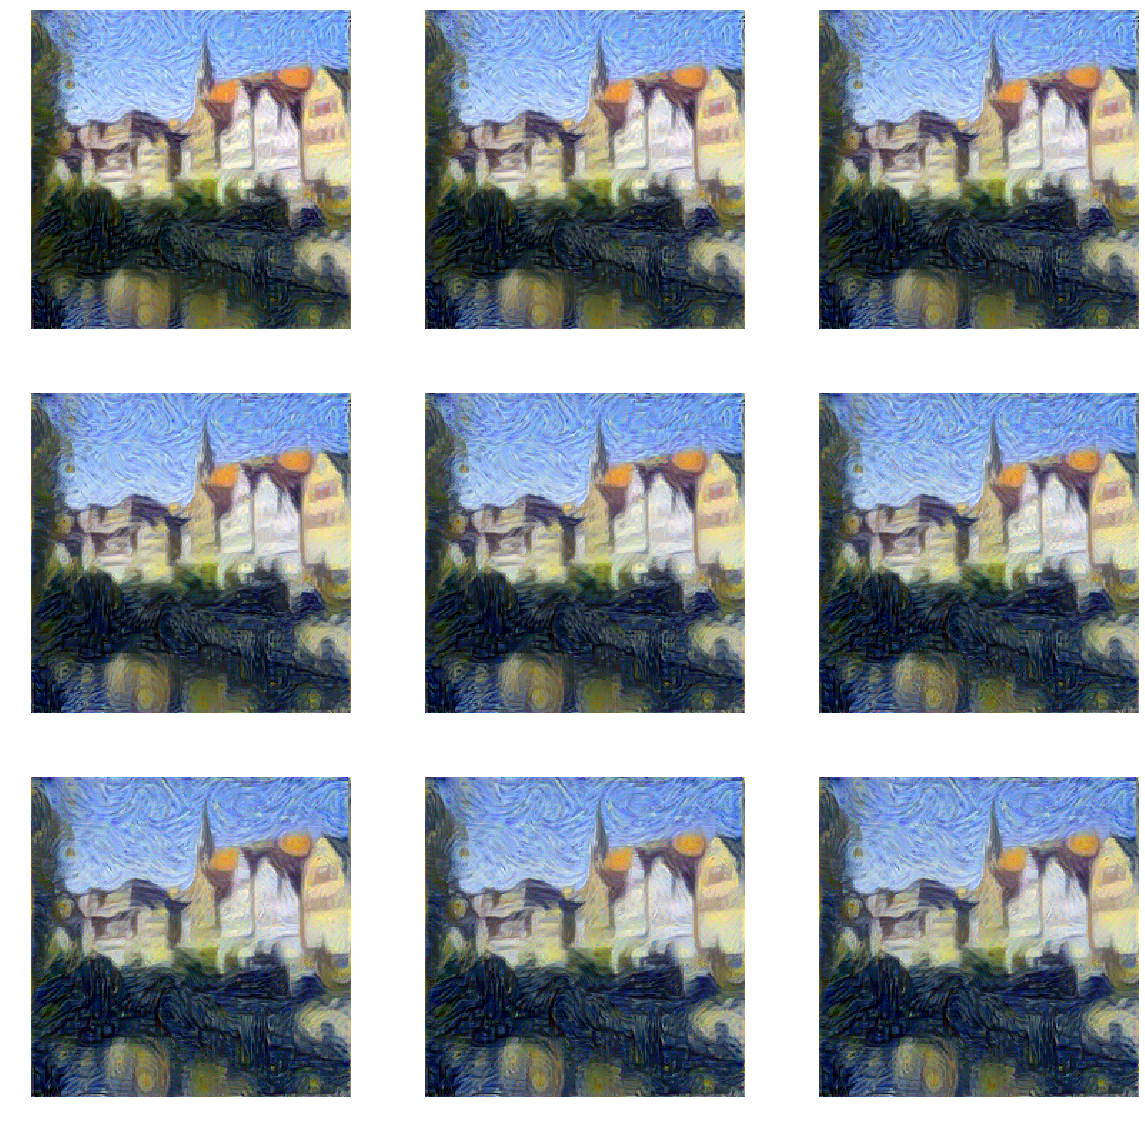

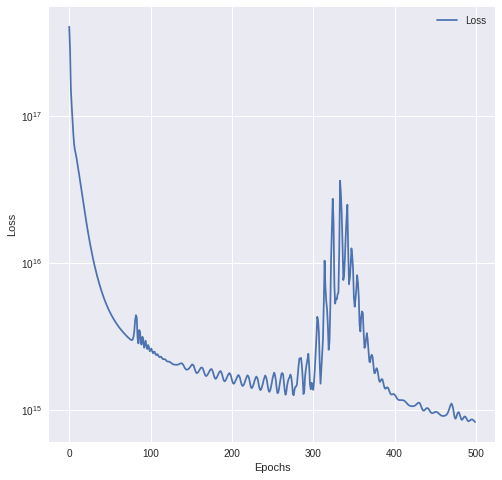

In [41]:
def scope():
  dataset = ImageDataset('/tmp/images/')
  content_image = dataset[0]
  style_image = dataset[1]
  
  input_image = content_image.clone().cuda()
  
  optimizer = optim.Adam([input_image.requires_grad_()], lr=.1)
  objective = ContentStyleLoss(content_image, style_image)
  
  losses = []
  
  num_epochs = 500
  loop = tqdm(total=num_epochs, position=0)
  
  fig=plt.figure(figsize=(20, 20))
  columns = 3
  rows = 3
  
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = objective(input_image)
    loss.backward(retain_graph=True)
    optimizer.step()
    gc.collect()
    
    losses.append(loss.item())
  
    input_image = normalize(input_image)
  
    frequency = num_epochs // (rows * columns)
    if epoch % frequency == 0 and epoch != 0:
      fig.add_subplot(rows, columns, epoch // frequency)
      show(input_image.cpu().detach())
      
    loop.set_description('loss:{:.4f}.'.format(loss.item())) # loss.item() returns the simple float loss, not the entire loss tensor
    loop.update(1)
    
  loop.close()
  fig = plt.figure(figsize=(8,8))
  plt.plot(range(len(losses)), losses, label='Loss')
  plt.yscale('log')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()
  
scope()